In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)
seed = 40
np.random.seed(seed)

In [3]:
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
del_0_v = -1/coefii
omega_0_v = 383.9911/coefii

In [4]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

def F(u_zegond,u_prime, u):       # DE, works with numpy arrays
    # print(len(u_zegond))
    # print(len(u_prime))
    # print(len(u))
    delta = u
    delta_prime = u_prime
    omega = delta_prime+ws
    omega_prime = u_zegond
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii


def F_E1(delta_prime, delta,omega_prime,omega, t):       # DE, works with numpy arrays
    return (delta_prime+ws-omega)
    # return X_prime+ws-Y 

def F_E2(delta_prime, delta,omega_prime,omega, t):       # DE, works with numpy arrays
    # return Y_prime
    return omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii

In [5]:
# t=np.random.uniform(0,1,size=50,requires_grad=False)
t = [0.0, 0.02040816326530612, 0.04081632653061224, 0.061224489795918366, 0.08163265306122448, 0.10204081632653061, 0.12244897959183673, 0.14285714285714285, 0.16326530612244897, 0.1836734693877551, 0.20408163265306123, 0.22448979591836735, 0.24489795918367346, 0.2653061224489796, 0.2857142857142857, 0.30612244897959184, 0.32653061224489793, 0.3469387755102041, 0.3673469387755102, 0.3877551020408163, 0.40816326530612246, 0.42857142857142855, 0.4489795918367347, 0.46938775510204084, 0.4897959183673469, 0.5102040816326531, 0.5306122448979592, 0.5510204081632653, 0.5714285714285714, 0.5918367346938775, 0.6122448979591837, 0.6326530612244898, 0.6530612244897959, 0.673469387755102, 0.6938775510204082, 0.7142857142857143, 0.7346938775510204, 0.7551020408163265, 0.7755102040816326, 0.7959183673469388, 0.8163265306122449, 0.8367346938775511, 0.8571428571428571, 0.8775510204081632, 0.8979591836734694, 0.9183673469387755, 0.9387755102040817, 0.9591836734693877, 0.9795918367346939, 1.0]


In [6]:
# # define embedding layer
# def embedding(x,wires):
#     qml.RY(x, wires=wires[1])

In [7]:
def embedding(x0,x1,wires):
    # qml.RY(np.arcsin(x0), wires=wires[0])
    # qml.RY(2*pi*x1, wires=wires[1])
    qml.RY(x0, wires=wires[0])
    qml.RY(x1, wires=wires[1])

In [8]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [9]:
# # define ansastz layer
# def layer(theta):
    
#     # Apply Hamiltonian matrix
#     Ham()
    
#     # Apply H gate
#     qml.Hadamard(0)
    
#     # rotations on qubit 1
#     qml.RY(theta,wires=1)
    
#     # CNOT
#     qml.CNOT(wires=[0, 1])

In [10]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubits
    qml.RY(theta[0],wires=0)
    qml.RY(theta[1],wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [11]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x0,x1):
    
    # encode data
    embedding(x0,x1,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [12]:
num_layers=4
theta1=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta2=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta = np.load('my_theta1.npy')
print(qml.draw(quantum_net)(theta1,0))

TypeError: quantum_net() missing 1 required positional argument: 'x1'

In [ ]:
def d_arcsin(x):
    return 1/(np.sqrt(1-x**2))

In [ ]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):
    r1=quantum_net(theta,t)[0]
    return w[0]+w[1]*r1+w[2]*r1**2


In [ ]:
def cost_finite(theta1,w,t):
    global current_loss

    loss_i = 0

    delta_0 = None  # boundary condition
    omega_0 = None  # boundary condition


    delta_0 = classical_quantum_net(theta1,w,t=t[0])

    Y = np.zeros(len(t) + 2)
    # print(type(delta_0))
    # print(type(delta_0._value))
    # x_0 is at the beginning of the domain, already calculated
    Y[1] = delta_0._value

    Y[0] = classical_quantum_net(theta1,w,t=t[0]-d_t)._value


    for i in range(1, len(t)):
        Y[i + 1] = classical_quantum_net(theta1,w,t=t[i])._value


    Y[len(t) + 1] = classical_quantum_net(theta1,w,t=t[0]+d_t)._value


    # Differentiation
    Y_prime = (Y[2:] - Y[:-2])/(2*d_t)
    omega_0 = Y_prime[0]+ws

    Y_zegond = (Y_prime[2:] - Y_prime[:-2])/(2*d_t)

    # print('==========')
    # print(Y_zegond)

    # loss_i += np.sum((F(Y_zegond,Y_prime[1:-1], Y[2:-2], t[1:-1]))**2)
    loss_i += np.sum((F(Y_zegond,Y_prime[1:-1], Y[2:-2]))**2)

    # boundary condition given a weight eta
    eta = 5    
    loss_b = eta * (delta_0 - del_0_v) ** 2 * len(t)
    loss_b += eta * (omega_0 - omega_0_v) ** 2 * len(t)



    current_loss = (loss_i+loss_b) / len(t)
    return current_loss

In [ ]:
# def cost(theta1,w1,t):

#     # loss inner points
#     loss_i = 0

#     del_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
#     del_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
#     omega_t_pred = del_t_prime+ws
#     # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
#     omega_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

#     loss_i += np.mean(F_E1(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)

#     # # loss boundary points
#     loss_b = 0
#     del_0_pred = classical_quantum_net(theta1,w1,0)
#     omega_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

#     # # print(U_0)
#     loss_b += (del_0_v-del_0_pred)**2+(omega_0_v-omega_0_pred)**2
#     return 2*loss_b + loss_i
#     # return 0.2*loss_b + 0.8*loss_i

#     return loss_i

In [ ]:
w1=np.zeros(3,requires_grad=True)
# w2=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [ ]:
start=now()
print(start)

2023-08-13 21:49:15.021120


In [ ]:
epochs=100
cost_max = 10000
theta1_best = None
w1_best = None

# theta1=np.load('theta40.npy')
# w1= np.load('w40.npy')


for e in range(1,epochs+1):

    # (theta1,theta2,w1,w2,_),_cost=opt.step_and_cost(cost,theta1,theta2,w1,w2,t)
    (theta1,w1,_),_cost=opt.step_and_cost(cost_finite,theta1,w1,t)

    if _cost<cost_max:
        cost_max = _cost
        theta1_best = theta1
        w1_best = w1

    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%1==0:
        print(f'Epoch: {e} | Cost: {_cost}')



Epoch: 1 | Cost: 1.249999999999988
Epoch: 2 | Cost: 0.8436393820004846
Epoch: 3 | Cost: 0.6885817953279467
Epoch: 4 | Cost: 0.556452620284956
Epoch: 5 | Cost: 0.4060125108528788
Epoch: 6 | Cost: 0.2747960187362624
Epoch: 7 | Cost: 0.17271585013204432
Epoch: 8 | Cost: 0.10914486350521298
Epoch: 9 | Cost: 0.08768611538109436
Epoch: 10 | Cost: 0.08901621509385568
Epoch: 11 | Cost: 0.09012639806968722
Epoch: 12 | Cost: 0.09100339347910809
Epoch: 13 | Cost: 0.0941005802554462
Epoch: 14 | Cost: 0.09776614242110918
Epoch: 15 | Cost: 0.10487716700237132
Epoch: 16 | Cost: 0.10852070180740128
Epoch: 17 | Cost: 0.09720956604365599
Epoch: 18 | Cost: 0.07991438733788207
Epoch: 19 | Cost: 0.0668150391487743
Epoch: 20 | Cost: 0.059004455412117934
Epoch: 21 | Cost: 0.05687400392585812
Epoch: 22 | Cost: 0.05906073399317454
Epoch: 23 | Cost: 0.060946088760864686
Epoch: 24 | Cost: 0.06183514891369194
Epoch: 25 | Cost: 0.06315124363786734
Epoch: 26 | Cost: 0.06294968265313765
Epoch: 27 | Cost: 0.060482210

In [ ]:
seed =20
np.save('theta'+str(seed), theta1)
np.save('w'+str(seed),w1)

In [ ]:
y_delta_real = [-0.1, -0.08568864375010266, -0.07135199292327042, -0.05703216366155178, -0.04277533332758968, -0.028630566403092566, -0.014648393492369936, -0.0008786099410683636, 0.012629993562057113, 0.025830965225360485, 0.03868190003112095, 0.05114514907683676, 0.06318818053413534, 0.07478349631699908, 0.08590929364185632, 0.09655108128205876, 0.10669910851327256, 0.11634802541217151, 0.12549688285643618, 0.13414913252475494, 0.1423124546002818, 0.14999727816970396, 0.1572170147933966, 0.16398646160587024, 0.17032150117763253, 0.17623910151518826, 0.18175731606103976, 0.18689528211221512, 0.19167252338163385, 0.1961073022258, 0.2002172705183872, 0.2040196495808423, 0.20753123018238517, 0.21076837254000894, 0.21374700631847987, 0.2164826306303374, 0.21899031403589397, 0.22128469454323552, 0.2233792634241711, 0.22528520015009165, 0.22701309424038968, 0.22857304585789437, 0.22997466468065175, 0.2312270699019247, 0.23233889023019288, 0.23331826388915283, 0.23417283861771784, 0.2349097716700181, 0.2355355471757422, 0.23605508170803655]
y_omega_real = [38.39911, 38.40131255162024, 38.401559501400065, 38.399627615014815, 38.39535272010845, 38.38863569037213, 38.37944575798523, 38.36781828175373, 38.35385457506316, 38.33771250498817, 38.31960064799821, 38.29975795463622, 38.27844654658136, 38.25594953663366, 38.232548774138536, 38.20852344187769, 38.184133101993716, 38.15961422638989, 38.135180196730154, 38.11102130443908, 38.0873045267779, 38.0641648590319, 38.04170495996719, 38.020008128295665, 37.999139183467754, 37.979144465672405, 37.96005183583712, 37.94187079269068, 37.92460193204962, 37.90823330461032, 37.892744190413474, 37.87811073974539, 37.864305973137945, 37.851299781368624, 37.83905892546051, 37.82754703668229, 37.816724616548235, 37.80654903681822, 37.7969789305147, 37.78797953688034, 37.779515522995986, 37.77155243468513, 37.76405670589686, 37.75699565870589, 37.75033750331248, 37.744051338042496, 37.73810714934741, 37.73247581180426, 37.72712975291509, 37.7220465421391]


In [ ]:
# print(_cost)
# t=np.random.uniform(0,1,size=50,requires_grad=False)
print(t)
pred_train_X=np.array([classical_quantum_net(theta1,w1,t) for t in t])
pred_train_Y=(np.array([classical_quantum_net_prime(theta1,w1,t) for t in t])+ws)
print(pred_train_X)
print(pred_train_Y)
# pred_train_Y=np.array([classical_quantum_net(theta2,w2,t) for t in t])

[0.0, 0.02040816326530612, 0.04081632653061224, 0.061224489795918366, 0.08163265306122448, 0.10204081632653061, 0.12244897959183673, 0.14285714285714285, 0.16326530612244897, 0.1836734693877551, 0.20408163265306123, 0.22448979591836735, 0.24489795918367346, 0.2653061224489796, 0.2857142857142857, 0.30612244897959184, 0.32653061224489793, 0.3469387755102041, 0.3673469387755102, 0.3877551020408163, 0.40816326530612246, 0.42857142857142855, 0.4489795918367347, 0.46938775510204084, 0.4897959183673469, 0.5102040816326531, 0.5306122448979592, 0.5510204081632653, 0.5714285714285714, 0.5918367346938775, 0.6122448979591837, 0.6326530612244898, 0.6530612244897959, 0.673469387755102, 0.6938775510204082, 0.7142857142857143, 0.7346938775510204, 0.7551020408163265, 0.7755102040816326, 0.7959183673469388, 0.8163265306122449, 0.8367346938775511, 0.8571428571428571, 0.8775510204081632, 0.8979591836734694, 0.9183673469387755, 0.9387755102040817, 0.9591836734693877, 0.9795918367346939, 1.0]
[-0.01829411 

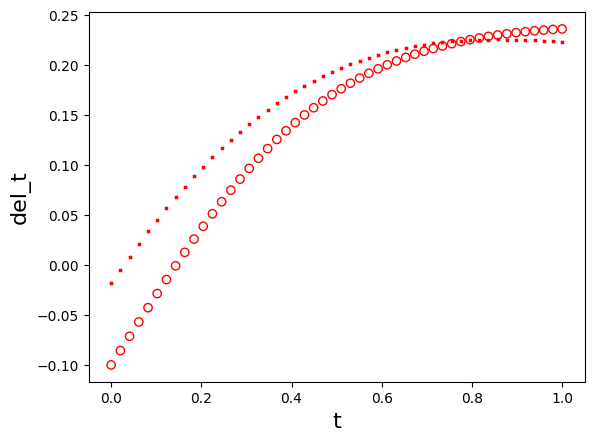

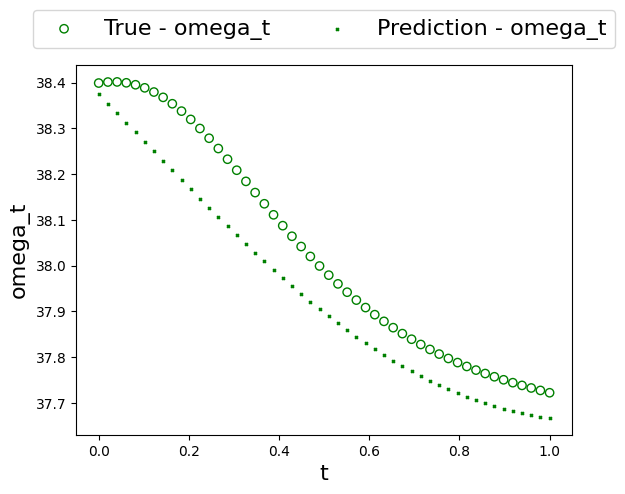

In [ ]:
plt.figure()

plt.scatter(t,y_delta_real,facecolors='none', edgecolors='r', label='True - del_t')
plt.scatter(t,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)
plt.figure()
plt.scatter(t,y_omega_real,facecolors='none', edgecolors='g', label='True - omega_t')

plt.scatter(t,pred_train_Y, color='green',marker="x",s=4,label='Prediction - omega_t')

plt.xlabel('t',fontsize=16)
plt.ylabel('omega_t',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()